## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [1]:
from pyspark.sql import SparkSession
from pyspark import HiveContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml import Pipeline


In [2]:
spark.sparkContext._conf.getAll()

[('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '10.30.30.21'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '44127'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1559696620353'),
 ('spark.app.name', 'PySparkShell')]

In [3]:
conf = spark.sparkContext._conf.setAll([
    ("hive.metastore.uris", "thrift://localhost:9083")])

In [4]:
spark.stop()

In [5]:
sc = SparkContext()

In [6]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [7]:
spark.sparkContext._conf.getAll()

[('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '10.30.30.21'),
 ('hive.metastore.uris', 'thrift://localhost:9083'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '44127'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1559696620353'),
 ('spark.app.name', 'PySparkShell')]

In [8]:
df = spark.sql("SHOW TABLES")
df.show()

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|boosting_output|      false|
| default|   movieratings|      false|
+--------+---------------+-----------+



In [9]:
# Load File from HDFS
# file_location = "/FileStore/tables/bank_additional_full_no_header-a99ad.csv"
file_location = 'hdfs:///user/labdata/marketing/bank-additional-full.csv'
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "false"
delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
df_marketing_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)



In [11]:
# Rename Column Names to the Original Header
DefColumnNames=df_marketing_data.schema.names
HeaderNames=['age','job','marital','education','default','housing','loan','contact','month','day_of_week','duration','campaign','pdays','previous',	'poutcome','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed','deposit']

for Idx in range(0,21):
    df_marketing_data=df_marketing_data.withColumnRenamed(DefColumnNames[Idx],HeaderNames[Idx])
df_marketing_data = df_marketing_data.drop ('duration')    
df_marketing_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- deposit: string (nullable = true)



In [12]:
categoricalColumns = []
numericCols = []
for i in df_marketing_data.dtypes:
    if i[1]=='string':
        categoricalColumns  += [i[0]]
    elif i[1]=='int' or i[1]=='double':
        numericCols  += [i[0]]

print(categoricalColumns)
print(numericCols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'deposit']
['age', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']


In [13]:
# Handling Categorical Columns using StringIndex/Encoder
#categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

stages = [] 
for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
  encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
  stages += [stringIndexer, encoder]
  
#numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']  
label_stringIdx = StringIndexer(inputCol = "deposit", outputCol = "label")
stages += [label_stringIdx]



In [14]:
## Assembler Inputs
assemblerInputs = ['jobclassVec', 'maritalclassVec', 'educationclassVec', 'defaultclassVec', 'housingclassVec', 'loanclassVec', 'contactclassVec', 'monthclassVec','day_of_weekclassVec','poutcomeclassVec'] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [15]:
## PipeLine
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df_marketing_data)
df_marketing_data_prep = pipelineModel.transform(df_marketing_data)
df_marketing_data_prep.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- deposit: string (nullable = true)
 |-- jobIndex: double (nullable = true)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = true)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex

In [16]:
df_marketing_data_prep.take(5)


[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp_var_rate=1.1, cons_price_idx=93.994, cons_conf_idx=-36.4, euribor3m=4.857, nr_employed=5191.0, deposit='no', jobIndex=8.0, jobclassVec=SparseVector(11, {8: 1.0}), maritalIndex=0.0, maritalclassVec=SparseVector(3, {0: 1.0}), educationIndex=4.0, educationclassVec=SparseVector(7, {4: 1.0}), defaultIndex=0.0, defaultclassVec=SparseVector(2, {0: 1.0}), housingIndex=1.0, housingclassVec=SparseVector(2, {1: 1.0}), loanIndex=0.0, loanclassVec=SparseVector(2, {0: 1.0}), contactIndex=1.0, contactclassVec=SparseVector(1, {}), monthIndex=0.0, monthclassVec=SparseVector(9, {0: 1.0}), day_of_weekIndex=1.0, day_of_weekclassVec=SparseVector(4, {1: 1.0}), poutcomeIndex=0.0, poutcomeclassVec=SparseVector(2, {0: 1.0}), depositIndex=0.0, depositclassVec=SparseVector(1, {0: 1.0}), lab

In [17]:
# Divisão dos Dados de Teste e Treino
(marketing_model_treino, marketing_model_teste) = df_marketing_data_prep.randomSplit([0.7, 0.3])


In [18]:
# Definindo Numero de Arvores
modelo =  RandomForestClassifier(featuresCol="features").setNumTrees(100)

In [19]:
# Preparing Training
modelo_fit = modelo.fit(marketing_model_treino)
print (modelo_fit.featureImportances)

(52,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51],[0.0006705108661640729,0.002161657683086589,0.0005734176579959931,0.0004262521511439382,0.0005186550150947832,0.001876269949621637,0.00033806297497945874,0.0005254846541944077,0.00012914979216743438,0.0001824983639196838,0.0023019694594873055,0.0004320687255771988,0.0006428226398941071,0.00046086577556948816,0.0010400789947641192,0.001001839658227274,0.0006372179396928386,0.0007021327845227091,0.00037192484910320196,0.0004380093705322684,0.0007737548377592699,0.0014062012698582776,0.0022709792853826427,0.0004719181364820079,0.000602041828061702,0.0005487355084603763,0.0005126693404563093,0.01474685246495978,0.014061021017010305,0.000980850736765406,0.0014174951207774685,0.0015541973495046399,0.0005814000024891434,0.01029875114058305,0.01624305623314624,0.0013857150078692812,0.011632603748333394,0.0017271708463932555,0.002833802140712272

In [21]:
# Saving Model HDFS
hdfs_path = "/user/labdata/modelo_RFT"
modelo_fit.write().overwrite().save(hdfs_path)



In [22]:
modelo_salvo = RandomForestClassificationModel.load(hdfs_path)

In [23]:
# Running Prediction
predict = modelo_salvo.transform(marketing_model_treino)

In [16]:
predict.show()

+---+-------+-------+-----------+-------+-------+-------+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+-------+--------+---------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+----------+-------------+----------------+-------------------+-------------+----------------+------------+---------------+-----+--------------------+--------------------+--------------------+----------+
age| job|marital| education|default|housing| loan| contact|month|day_of_week|duration|campaign|pdays|previous| poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|deposit|jobIndex| jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|monthIndex|monthclassVec|day_of_weekIndex|day_of_weekclassVec|poutcomeIndex|poutcomeclassVec|depositIndex|depositclassVec|label| features| rawPrediction| probability|prediction|
+---+-------+-------+-----------+-------+-------+-------+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+-------+--------+---------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+----------+-------------+----------------+-------------------+-------------+----------------+------------+---------------+-----+--------------------+--------------------+--------------------+----------+
 18|student| single| basic.4y| no| no| no| cellular| apr| thu| 108| 1| 999| 0|nonexistent| -1.8| 93.075| -47.1| 1.365| 5099.1| no| 10.0|(11,[10],[1.0])| 1.0| (3,[1],[1.0])| 4.0| (7,[4],[1.0])| 0.0| (2,[0],[1.0])| 1.0| (2,[1],[1.0])| 0.0|(2,[0],[1.0])| 0.0| (1,[0],[1.0])| 5.0|(9,[5],[1.0])| 0.0| (4,[0],[1.0])| 0.0| (2,[0],[1.0])| 0.0| (1,[0],[1.0])| 0.0|(53,[10,12,18,21,...|[89.0701043154089...|[0.89070104315408...| 0.0|
 18|student| single| basic.4y| no| yes| yes| cellular| apr| thu| 184| 2| 999| 0|nonexistent| -1.8| 93.075| -47.1| 1.365| 5099.1| no| 10.0|(11,[10],[1.0])| 1.0| (3,[1],[1.0])| 4.0| (7,[4],[1.0])| 0.0| (2,[0],[1.0])| 0.0| (2,[0],[1.0])| 1.0|(2,[1],[1.0])| 0.0| (1,[0],[1.0])| 5.0|(9,[5],[1.0])| 0.0| (4,[0],[1.0])| 0.0| (2,[0],[1.0])| 0.0| (1,[0],[1.0])| 0.0|(53,[10,12,18,21,...|[88.1614910545486...|[0.88161491054548...| 0.0|
 18|student| single|high.school| no| no| no|telephone| nov| thu| 75| 1| 999| 0|nonexistent| -0.1| 93.2| -42.0| 4.245| 5195.8| no| 10.0|(11,[10],[1.0])| 1.0| (3,[1],[1.0])| 1.0| (7,[1],[1.0])| 0.0| (2,[0],[1.0])| 1.0| (2,[1],[1.0])| 0.0|(2,[0],[1.0])| 1.0| (1,[],[])| 4.0|(9,[4],[1.0])| 0.0| (4,[0],[1.0])| 0.0| (2,[0],[1.0])| 0.0| (1,[0],[1.0])| 0.0|(53,[10,12,15,21,...|[93.5213641872117...|[0.93521364187211...| 0.0|
 18|student| single|high.school| no| yes| yes| cellular| mar| tue| 103| 1| 999| 0|nonexistent| -1.8| 92.843| -50.0| 1.687| 5099.1| no| 10.0|(11,[10],[1.0])| 1.0| (3,[1],[1.0])| 1.0| (7,[1],[1.0])| 0.0| (2,[0],[1.0])| 0.0| (2,[0],[1.0])| 1.0|(2,[1],[1.0])| 0.0| (1,[0],[1.0])| 8.0|(9,[8],[1.0])| 3.0| (4,[3],[1.0])| 0.0| (2,[0],[1.0])| 0.0| (1,[0],[1.0])| 0.0|(53,[10,12,15,21,...|[81.2251155137767...|[0.81225115513776...| 0.0|
 19|student| single| basic.4y| no| no| yes| cellular| apr| wed| 371| 2| 999| 0|nonexistent| -1.8| 93.075| -47.1| 1.405| 5099.1| yes| 10.0|(11,[10],[1.0])| 1.0| (3,[1],[1.0])| 4.0| (7,[4],[1.0])| 0.0| (2,[0],[1.0])| 1.0| (2,[1],[1.0])| 1.0|(2,[1],[1.0])| 0.0| (1,[0],[1.0])| 5.0|(9,[5],[1.0])| 2.0| (4,[2],[1.0])| 0.0| (2,[0],[1.0])| 1.0| (1,[],[])| 1.0|(53,[10,12,18,21,...|[87.3896261662517...|[0.87389626166251...| 0.0|
 19|student| single| basic.6y| no| no| no| cellular| mar| tue| 136| 1| 999| 0|nonexistent| -1.8| 92.843| -50.0

In [24]:
exibe_colunas = predict.select(['age','probability','label','prediction'])

In [25]:
exibe_colunas.show()

+---+--------------------+-----+----------+
|age|         probability|label|prediction|
+---+--------------------+-----+----------+
| 18|[0.77454038145034...|  0.0|       0.0|
| 18|[0.77126954811700...|  0.0|       0.0|
| 18|[0.93229045760570...|  0.0|       0.0|
| 18|[0.69587427804269...|  0.0|       0.0|
| 19|[0.80773746982928...|  1.0|       0.0|
| 19|[0.66840544485366...|  1.0|       0.0|
| 19|[0.81160853535051...|  0.0|       0.0|
| 19|[0.80833780760600...|  1.0|       0.0|
| 19|[0.68527055498378...|  1.0|       0.0|
| 19|[0.93690136560285...|  0.0|       0.0|
| 19|[0.80784561318732...|  1.0|       0.0|
| 19|[0.80784550759851...|  1.0|       0.0|
| 19|[0.80614291425943...|  1.0|       0.0|
| 19|[0.80614280867061...|  0.0|       0.0|
| 19|[0.87714957827532...|  0.0|       0.0|
| 19|[0.80844698062204...|  0.0|       0.0|
| 19|[0.80739235232994...|  1.0|       0.0|
| 19|[0.80866507726509...|  0.0|       0.0|
| 19|[0.80614291425943...|  1.0|       0.0|
| 20|[0.94200469061399...|  0.0|

In [26]:
##
results = predict.select(['probability', 'label'])

In [27]:
# Persiste Modelo Na Base
import pyspark
df_writer = pyspark.sql.DataFrameWriter(predict)
df_writer.saveAsTable('default.random_forest_output', format='parquet', mode='overwrite')

In [28]:
#
spark.sql("SELECT * FROM default.boosting_output").show()

+---+-------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+--------+---------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+----------+-------------+----------------+-------------------+-------------+----------------+------+-------------+-----+--------------------+--------------------+--------------------+----------+
|age|    job|marital|  education|default|housing|loan|  contact|month|day_of_week|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|jobIndex|    jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|monthIndex|monthclassVec|day_of_weekI

In [29]:
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

In [30]:
metrics = metric(scoreAndLabels)
print("AUC (numTrees=100): ", metrics.areaUnderROC)

AUC (numTrees=100):  0.8040772169758128


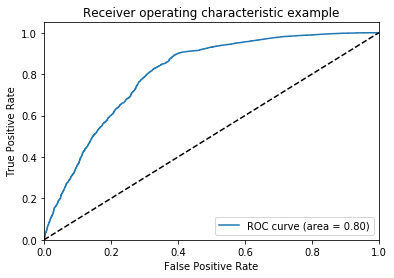

In [31]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
display()

In [32]:
import pyspark.sql.functions as func
pred_results = predict.withColumn('compara', func.when(func.col("label") == func.col("prediction"), "Y").otherwise("N"))
print("Taxa de Acerto: ", round(pred_results[pred_results['compara']=='Y'].count() / pred_results.count() * 100, 2),"%")

Taxa de Acerto:  90.01 %
